In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import torch
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd
import uuid
from pydantic import BaseModel
import torch
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
import qdrant_client
import getpass
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load env

In [102]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_Key")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

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


# Load embedding model

In [15]:
model_embedding = HuggingFaceEmbeddings(
    model_name='hiieu/halong_embedding',
    model_kwargs={'device': 'cpu'},
    encode_kwargs= {'normalize_embeddings': False}
)

# Vector store

In [23]:
client = qdrant_client.QdrantClient(   
    url=QDRANT_URL, 
    api_key=QDRANT_API_KEY,
)

vector_store = QdrantVectorStore(
    client=client, 
    collection_name="qa_tvpl",
    embedding=model_embedding
)

In [41]:
query = "Tấn công an ninh mạng là gì?"
found_docs = vector_store.similarity_search(
    query,
    k=5)

In [42]:
print(found_docs[0])

page_content='Căn cứ khoản 1 Điều 21 Luật An ninh mạng 2018 quy định như sau:
Phòng ngừa, xử lý tình huống nguy hiểm về an ninh mạng
1. Tình huống nguy hiểm về an ninh mạng bao gồm:
a) Xuất hiện thông tin kích động trên không gian mạng có nguy cơ xảy ra bạo loạn, phá rối an ninh, khủng bố;
b) Tấn công vào hệ thống thông tin quan trọng về an ninh quốc gia;
c) Tấn công nhiều hệ thống thông tin trên quy mô lớn, cường độ cao;
d) Tấn công mạng nhằm phá hủy công trình quan trọng về an ninh quốc gia, mục tiêu quan trọng về an ninh quốc gia;
đ) Tấn công mạng xâm phạm nghiêm trọng chủ quyền, lợi ích, an ninh quốc gia; gây tổn hại đặc biệt nghiêm trọng trật tự, an toàn xã hội, quyền và lợi ích hợp pháp của cơ quan, tổ chức, cá nhân.
...
Theo đó, tình huống nguy hiểm về an ninh mạng bao gồm:
- Xuất hiện thông tin kích động trên không gian mạng có nguy cơ xảy ra bạo loạn, phá rối an ninh, khủng bố;
- Tấn công vào hệ thống thông tin quan trọng về an ninh quốc gia;
- Tấn công nhiều hệ thống thông ti

# LLM

In [104]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [108]:
llm = ChatGroq(
    temperature=0, 
    groq_api_key=GROQ_API_KEY, 
    model_name="llama-3.1-8b-instant"
)


In [112]:

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Bạn là một trợ lý ảo nhiệt tình và thành thật tư vấn về luật pháp.
            Bạn sẽ dựa trên các thông tin được cung cấp để trả lời các câu hỏi của người dùng.
            Tuyệt đối không được bịa ra câu trả lời, nếu không biết bạn phải trả lời không biết.
            Không trả lời các câu hỏi vô nghĩa, không liên quan.
            Dựa vào thông tin sau trả lời câu hỏi:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "context": "",
        "input": "mẹ của ba thì tôi gọi là gì ?",
    }
)

AIMessage(content='Theo quan hệ gia đình, mẹ của bố (hay cha) là bà.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 133, 'total_tokens': 150, 'completion_time': 0.022666667, 'prompt_time': 0.033527176, 'queue_time': 0.001512144, 'total_time': 0.056193843}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-beb8ab10-4a54-49b9-a351-d34462d939b9-0', usage_metadata={'input_tokens': 133, 'output_tokens': 17, 'total_tokens': 150})

# RAG

In [113]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [123]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=5)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"input": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [124]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

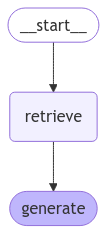

In [125]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
result = graph.invoke({"question": "Các án phạt khi vi phạm luật an ninh mạng?"})

print(f'Context: {result["context"]}\n----------------------------------------------------')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'sub_title': '06 hành vi bị nghiêm cấm khi sử dụng không gian mạng?', 'url': 'https://thuvienphapluat.vn/phap-luat/chill-guy-la-gi-du-trend-chill-guy-co-nang-thu-gian-anh-chang-thu-gian-chuan-quy-tac-ung-xu-tren-ma-364375-188580.html', 'date_published': '29/11/2024', 'author': 'Trịnh Lê Vy', '_id': 'b5012f37-4727-4930-9b01-5a1bb802259a', '_collection_name': 'qa_tvpl'}, page_content='06 hành vi bị nghiêm cấm sử dụng không gian mạng được quy định tại khoản 1 Điều 8 Luật An ninh mạng 2018 như sau:\n(1) Hành vi quy định tại khoản 1 Điều 18 Luật An ninh mạng 2018;\n(2) Tổ chức, hoạt động, câu kết, xúi giục, mua chuộc, lừa gạt, lôi kéo, đào tạo, huấn luyện người chống Nhà nước Cộng hòa xã hội chủ nghĩa Việt Nam;\n(3) Xuyên tạc lịch sử, phủ nhận thành tựu cách mạng, phá hoại khối đại đoàn kết toàn dân tộc, xúc phạm tôn giáo, phân biệt đối xử về giới, phân biệt chủng tộc;\n(4) Thông tin sai sự thật gây hoang mang trong Nhân dân, gây thiệt hại cho hoạt động kinh tế 